<a href="https://colab.research.google.com/github/lephuocdat2000/-CS114.K21-/blob/master/GenderClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo pip install mtcnn
import mtcnn
print(mtcnn.__version__)

     |████████████████████████████████| 2.3MB 2.7MB/s 


Using TensorFlow backend.


0.1.0


In [2]:
from PIL import Image
from mtcnn.mtcnn import MTCNN
import pandas as pd
import numpy as np 
from numpy import savez_compressed
from numpy import asarray
from numpy import expand_dims
from os import listdir
from os.path import isdir
import matplotlib.pyplot as plt


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

In [7]:
main_folder='/content/drive/My Drive/Final_Project/'
images_folder=main_folder + 'face/'
df_attr=pd.read_excel(main_folder+'gender_dataset.xlsx',)

In [ ]:
# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	for filename in list(directory):
		path=images_folder + filename
		face = extract_face(path)
		faces.append(face)
	return faces
	
from sklearn.model_selection import train_test_split
x=df_attr['Id_image']
y=df_attr['Male']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
arr_faces_test=load_faces(x_test)
savez_compressed('faces-dataset.npz', arr_faces_train, y_train, arr_faces_test, y_test)

Face Embedding

In [9]:
face_dataset=main_folder+'faces-dataset.npz'
from keras.models import load_model
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')/255.0
	# standardize pixel values across channels (global)
	#mean, std = face_pixels.mean(), face_pixels.std()
	#face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

data=np.load(face_dataset)
trainX,trainY,testX,testY=data['arr_0'],data['arr_1'],data['arr_2'],data['arr_3']
print('Loaded: ', trainX.shape, trainY.shape, testX.shape, testY.shape)
model = load_model(main_folder+'facenet_keras.h5')
print('Loaded Model')
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('faces-embeddings.npz', newTrainX, trainY, newTestX, testY)



Loaded:  (1600, 160, 160, 3) (1600,) (400, 160, 160, 3) (400,)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loaded Model
(1600, 128)
(400, 128)


StandardScaler 


In [14]:
# load dataset
#data = np.load('faces-embeddings.npz')
#trainX, trainY, testX, testY = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
from sklearn.preprocessing import Normalizer
# normalize input vectors
in_encoder = Normalizer(norm='l2')
newTrainX = in_encoder.transform(newTrainX)
newTestX = in_encoder.transform(newTestX)

In [15]:
newTrainX

array([[ 0.07275098,  0.0513428 , -0.10503177, ...,  0.033368  ,
        -0.05006744,  0.0745522 ],
       [ 0.14117606,  0.02114477, -0.0333598 , ..., -0.1593016 ,
        -0.14777671, -0.09666583],
       [-0.12818168, -0.1227126 ,  0.05822965, ..., -0.04477336,
         0.0517816 ,  0.04847284],
       ...,
       [-0.05984053,  0.07965881, -0.04181508, ..., -0.1355505 ,
         0.02351378,  0.04925385],
       [ 0.07499793,  0.0777225 , -0.07009255, ..., -0.12750953,
         0.05149288, -0.11747175],
       [ 0.10971787, -0.00401484,  0.03095755, ..., -0.04839855,
         0.04401036, -0.10745557]], dtype=float32)

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
from sklearn.model_selection import cross_val_score
results = []
names = []
for name, model in models:
  	cv_results = cross_val_score(model, newTrainX,trainY, cv=10, scoring='accuracy')
  	results.append(cv_results)
  	names.append(name)
  	print(name, cv_results.mean()) 

LR 0.911875
KNN 0.97875
RF 0.9362499999999999
DTC 0.771875
NB 0.8975
SVM 0.821875


In [46]:
pre_model=KNeighborsClassifier()
pre_model.fit(newTrainX,trainY)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [50]:
predict_train=pre_model.predict(newTrainX)

In [51]:
predict_y=pre_model.predict(newTestX)

In [52]:
from sklearn.metrics import accuracy_score
print(accuracy_score(testY, predict_y))
accuracy_score(trainY,predict_train)

0.98


0.98375

In [ ]:
def Prediction(img,model=final_model,train=newTrainX):
   


In [117]:
from google.colab import files
pixel=extract_face('/content/images.jpg')
arr=get_embedding(model,pixel)
samples = expand_dims(arr, axis=0)
pre=final_model.predict(samples)
if (pre[0]==0): print("Nu")
else: print("Nam")


Nu


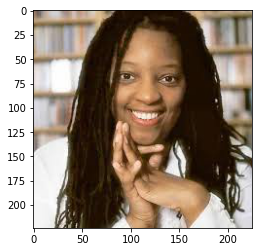

In [118]:
im=Image.open('/content/images.jpg')
im=asarray(im)
plt.imshow(im)

{'kernel': 'rbf'}